In [1]:
!pip install mediapipe
#install pre-trained model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.6/33.6 MB 31.4 MB/s eta 0:00:0000:0100:01


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Pre-proccessing


Since the CNN model using all pixels has the problem of overfitting and lack of generalization ability, using body landmarks might be better

## Using NumPy array


In [ ]:
import os
import numpy as np
import cv2
import mediapipe as mp
#This function detect the body landmarks from all the images in a folder and output an array with size(30,33,2) that contains the landmakrs
def detect_landmarks(image_folder):
    mp_holistic = mp.solutions.holistic.Holistic()
    image_files = sorted(os.listdir(image_folder))
    num_frames = len(image_files)
    num_landmarks = 33  # Fixed number of landmarks for pose estimation
    landmarks = np.zeros((num_frames,num_landmarks, 2))

    for i, file in enumerate(image_files):
        image_path = os.path.join(image_folder, file)
        frame = cv2.imread(image_path)

        # Convert the frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detect landmarks
        results = mp_holistic.process(frame_rgb)

        if results.pose_landmarks:
            for j, landmark in enumerate(results.pose_landmarks.landmark):
                landmarks[i, j,] = [landmark.x, landmark.y]

    mp_holistic.close()
    return landmarks


# Example usage:
image_folder = "/kaggle/input/gesture-recognition/train/WIN_20180907_15_35_09_Pro_Right Swipe_new"
landmarks = detect_landmarks(image_folder)
#np.save('/kaggle/working/landmarks.npy', landmarks)


In [ ]:
#load data doc
dataset_path = "/kaggle/input/gesture-recognition"
train_csv = pd.read_csv('/kaggle/input/train-doc/train_new.csv')
train_csv.head()
train_csv.shape

### initialize empty array for the data

In [ ]:
train_size = train_csv.shape
i = 0
label = []
Name = []
train_landmarks = np.empty((662,30,66))

### literate the data set and process the data

In [ ]:
for n in range(train_size[0]):
    subPath = train_csv.loc[n,'File'] #get name of the sub file from train_csv
    folder_path = '/kaggle/input/gesture-recognition/train/'+subPath #path of the subfile
    print(folder_path )
    print(n)
    train_landmarks[n] = detect_landmarks(folder_path).reshape((30, 66))
    label.append(train_csv.loc[n,'Inde'])
    Name.append(train_csv.loc[n,'Name'])
np.save('/kaggle/working/train_landmarks.npy', train_landmarks)
np.save('/kaggle/working/label.npy',label)
np.save('/kaggle/working/name.npy',Name)
print(50*"=")
print('saved')

In [ ]:
label = []
for n in range(train_size[0]):
    subPath = train_csv.loc[n,'File'] #get name of the sub file from train_csv
    folder_path = '/kaggle/input/gesture-recognition/train/'+subPath #path of the subfile
    label.append(train_csv.loc[n,'Inde'])

In [3]:
#run this cell if data were loaded somewhere
y=np.load("/kaggle/input/ppdata/label.npy")
X=np.load("/kaggle/input/ppdata/train_landmarks.npy")

In [ ]:
y = np.array(label)
X = train_landmarks

In [4]:
y.shape

(662,)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (529, 30, 66)
y_train shape: (529,)
X_test shape: (133, 30, 66)
y_test shape: (133,)


In [11]:
X_train.shape

(529, 30, 66)

In [12]:

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
CLASS_NAMES=['Left_Swipe_new','Right_Swipe_new','Stop_new','Thumbs_Down_new','Thumbs_Up_new']

In [40]:
# Build Model
model = Sequential([
    layers.Input(shape=(30,66)),
    layers.GRU(64, return_sequences=False),
    layers.Dense(len(CLASS_NAMES), activation="softmax")
])
model.compile(
    optimizer=optimizers.Adam(0.001), 
    loss="sparse_categorical_crossentropy", 
    metrics=["accuracy"]
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 64)                25344     
                                                                 
 dense_4 (Dense)             (None, 5)                 325       
                                                                 
Total params: 25,669
Trainable params: 25,669
Non-trainable params: 0
_________________________________________________________________


In [41]:
filepath = "/kaggle/working/"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_accuracy', save_weights_only=True, save_best_only=True, verbose=1
)
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test), 
    epochs=60,
    callbacks=[checkpoint],
)

Epoch 1/60
13/17 [=====================>........] - ETA: 0s - loss: 1.5984 - accuracy: 0.2356 
Epoch 1: val_accuracy improved from -inf to 0.36090, saving model to /kaggle/working/
17/17 [==============================] - 3s 34ms/step - loss: 1.5827 - accuracy: 0.2457 - val_loss: 1.4975 - val_accuracy: 0.3609
Epoch 2/60
14/17 [=======================>......] - ETA: 0s - loss: 1.4582 - accuracy: 0.4397
Epoch 2: val_accuracy improved from 0.36090 to 0.48872, saving model to /kaggle/working/
17/17 [==============================] - 0s 8ms/step - loss: 1.4555 - accuracy: 0.4442 - val_loss: 1.3824 - val_accuracy: 0.4887
Epoch 3/60
14/17 [=======================>......] - ETA: 0s - loss: 1.3481 - accuracy: 0.5156
Epoch 3: val_accuracy improved from 0.48872 to 0.50376, saving model to /kaggle/working/
17/17 [==============================] - 0s 8ms/step - loss: 1.3413 - accuracy: 0.5161 - val_loss: 1.3096 - val_accuracy: 0.5038
Epoch 4/60
13/17 [=====================>........] - ETA: 0s - los

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, 64)                25344     
                                                                 
 dense_4 (Dense)             (None, 5)                 325       
                                                                 
Total params: 25,669
Trainable params: 25,669
Non-trainable params: 0
_________________________________________________________________
5/5 [==============================] - 0s 2ms/step


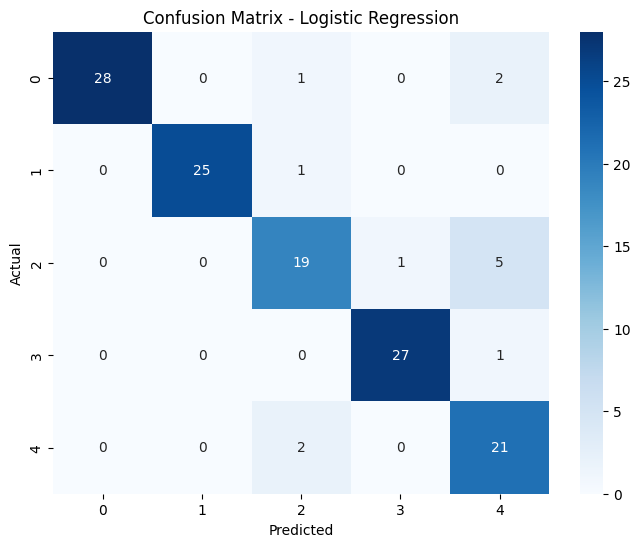

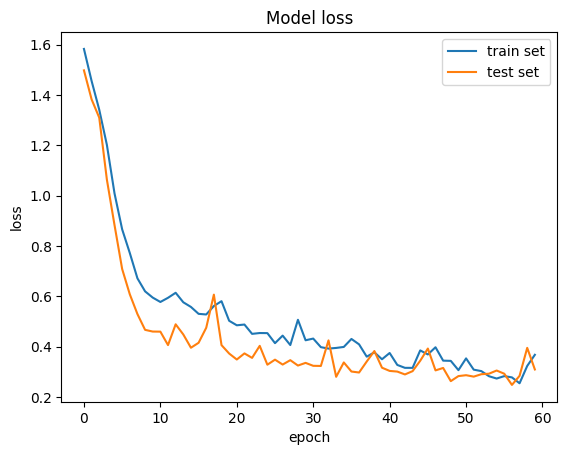

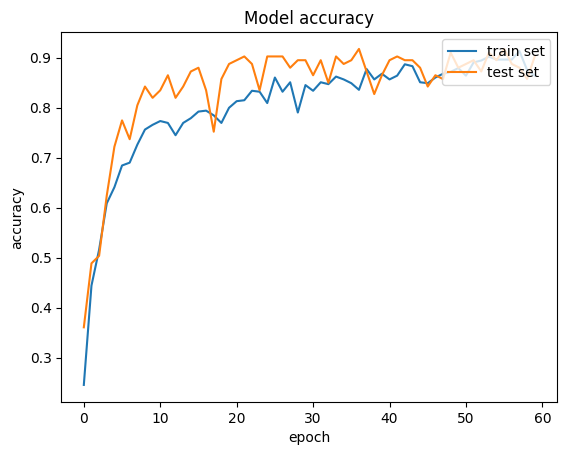

In [42]:
model.save("/kaggle/working/231008RNNV5.h5")
model2=tf.keras.models.load_model("/kaggle/working/231008RNNV5.h5")
model2.summary()
predictions = model2.predict(X_test)
y_pred = np.argmax(predictions, axis=-1)
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
cm=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train set', 'test set'], loc='upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train set', 'test set'], loc='upper right')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have X_test and y_test as the test data

# Make predictions on the test data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get class labels
#class_names = ["Class 0", "Class 1", "Class 2", ...]  # Replace with your class names

# Create a figure and axes
fig, ax = plt.subplots()

# Create a heatmap
heatmap = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax)

# Set axis labels and title
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
ax.set_title("Confusion Matrix")

# Set x-tick and y-tick labels
heatmap.set_xticklabels(CLASS_NAMES, rotation=45, ha="right")
heatmap.set_yticklabels(CLASS_NAMES, rotation=0)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
selected_part = X_test[0]  # Select the first part
reshaped_part = selected_part.reshape(1, 30, 66)
model.predict(reshaped_part)
print(y_test[0])

In [ ]:
import random
#num = random.randint(0,132)
correct = 0
for num in range(133):
    selected_part = X_test[num]  # Select the first part
    reshaped_part = selected_part.reshape(1, 30, 66)
    result = model.predict(reshaped_part)
    if np.argmax(result) == y_test[num]:
        correct+=1
        #print(f"accuracy:{correct/num}")
print(correct/133)

In [ ]:
import cv2
import os

def split_video(video_path, output_dir, num_frames=30):
    # 创建输出目录（如果不存在）
    os.makedirs(output_dir, exist_ok=True)

    # 加载视频
    video_capture = cv2.VideoCapture(video_path)

    # 获取视频的总帧数
    total_frames = int(video_capture.get(cv2.CAP_PROP_FRAME_COUNT))

    # 计算帧间隔
    frame_interval = max(total_frames // num_frames, 1)  # 确保至少输出一帧

    # 初始化计数器和帧索引
    count = 0
    frame_index = 0

    # 逐帧读取视频，并保存每个第frame_interval帧的图像
    while video_capture.isOpened():
        ret, frame = video_capture.read()

        if not ret:
            break

        # 保存每个第frame_interval帧
        if frame_index % frame_interval == 0:
            output_path = os.path.join(output_dir, f"frame_{count}.jpg")
            cv2.imwrite(output_path, frame)
            count += 1

        frame_index += 1

        # 当达到指定的图像数量时停止
        if count == num_frames:
            break

    # 释放视频捕获对象
    video_capture.release()

    print(f"视频分割完成！共保存 {count} 张图像。")

# 示例用法
video_path = "/kaggle/input/train-doc/VID_20230930_122119.mp4"  # 输入视频的路径
output_dir = "output_frames"  # 输出图像的目录

split_video(video_path, output_dir, num_frames=30)

In [ ]:
a = detect_landmarks("/kaggle/working/output_frames")
print(a.shape)
a_use = a.reshape(1, 30, 66)
r = model.predict(a_use)
print(CLASS_NAMES[np.argmax(r)])


In [ ]:
!rm -rf /kaggle/working/

# 推理

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
#landmarks detection, input folder contains 30 frames, output an array
def detect_landmarks(frames):
    mp_holistic = mp.solutions.holistic.Holistic()
    num_frames = len(frames)
    num_landmarks = 33  # Fixed number of landmarks for pose estimation
    landmarks = np.zeros((num_frames, num_landmarks, 2))

    for i, frame in enumerate(frames):
        # Convert the frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Detect landmarks
        results = mp_holistic.process(frame_rgb)

        if results.pose_landmarks:
            for j, landmark in enumerate(results.pose_landmarks.landmark):
                landmarks[i, j, :] = [landmark.x, landmark.y]

    mp_holistic.close()
    return landmarks
def inference(X):
    CLASS_NAMES=['Left_Swipe_new','Right_Swipe_new','Stop_new','Thumbs_Down_new','Thumbs_Up_new']
    y_pred=np.argmax(model.predict(X), axis=1)
    #print(y_pred)
    print(CLASS_NAMES[y_pred[0]])
    return y_pred

In [ ]:
frames2=[]
image_files = sorted(os.listdir('/kaggle/input/gesture-recognition/train/WIN_20180907_15_35_09_Pro_Right Swipe_new'))
num_frames = len(image_files)

for i, file in enumerate(image_files):
    image_path = os.path.join(image_folder, file)
    frame = cv2.imread(image_path)
    frames2.append(frame)
b=detect_landmarks(frames2).reshape((1,30, 66))
inference(b)

In [ ]:
frames=[]
frame_count=0
while True:
        ret,frame=cap.read()
        if ret:
            frames.append(frame)
            frame_count+=1
            
            if frame_count == 30:
                X_data = detect_landmarks(frames)
                inference(X_data)
                
                frame_count=0
                frames=[]
            cv2.imshow('Camera',frame)
            
        if cv2.waitKey(1)&0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows
                
            

In [ ]:
import cv2
import os

def merge_frames_to_video(frames_folder, output_video_path, fps=30.0):
    # 获取文件夹中的所有图像文件
    image_files = sorted([f for f in os.listdir(frames_folder) if f.endswith('.png')])

    if len(image_files) == 0:
        print("文件夹中没有找到图像文件。")
        return

    # 获取第一个图像文件的尺寸
    first_image_path = os.path.join(frames_folder, image_files[0])
    first_image = cv2.imread(first_image_path)
    height, width, _ = first_image.shape

    # 创建视频编写器
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # 也可以尝试其他视频编码器
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

    # 逐帧读取图像文件并写入视频
    for image_file in image_files[:30]:  # 仅使用前30帧
        image_path = os.path.join(frames_folder, image_file)
        frame = cv2.imread(image_path)
        video_writer.write(frame)

    # 释放视频编写器
    video_writer.release()

    print("视频合并完成。")

# 输入文件夹路径和输出视频路径
frames_folder = "/kaggle/input/gesture-recognition/train/WIN_20180907_15_49_14_Pro_Thumbs Down_new"
output_video_path = "/kaggle/working/up2.mp4"

# 合并图像帧为视频
merge_frames_to_video(frames_folder, output_video_path)